In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-09-07 08:46:14--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-09-07 08:46:14 (6.00 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
dir = r'/content/'
words = open(dir+'/names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [ ]:
# Build Vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

In [ ]:
#create training set (x,y)
def build_dataset(words):
    block_size = 3 # berapa karakter pendahulu yang dipakai untuk memprediksi karakter setelahnya
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context) , ' ---> ',itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [ ]:
#Splitting Data Train, Dev, Test (80%, 10%, 10%)
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9* len(words))

X_tr, Y_tr = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_te, Y_te = build_dataset(words[n2:])

In [ ]:
print(X_tr.shape,Y_tr.shape)
print(X_dev.shape,Y_dev.shape)
print(X_te.shape,Y_te.shape)

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [ ]:
g = torch.Generator().manual_seed(2147483647)

In [ ]:
#C adalah embedding vektor dimana tiap karakter akan di proyeksikan ke dalam vektor C
C = torch.randn((27,10), generator = g, requires_grad=True)
#tensor emb memiliki dimensi (32,3,2) yang menggambarkan:
# 32 : jumlah data latih X, setelah dilakukan slicing sesuai ukuran batch size (ini bisa berubah tergantung jumlah datanya)
# 3  : jumlah karakter(block_size)
# 2  : jumlah dimensi embeddingnya, dalam contoh ini di embed ke 10 dimensi

In [ ]:
#inisiasi parameter

W1 = torch.randn((30,200),generator = g, requires_grad=True)
b1 = torch.randn(200, generator = g, requires_grad=True)
W2 = torch.randn((200,27), generator = g, requires_grad=True)
b2 = torch.randn(27, generator = g, requires_grad=True)
parameters = [C,W1,b1,W2,b2]
print(f'jumlah parameter :  {sum(p.nelement() for p in parameters)}')

jumlah parameter :  11897


    
    #menghitung NLL :
    # hitung softmax dari logit sebagai probability distribusi dari semua kemungkinan output
    # ambil nilai probabilitas memprediksi nilai Y untuk tiap baris data
    # disini kita menginginkan nilai prob untuk tiap2 baris data pada index ke Y mendekati 1 (memaksimalkan nilai probabilitas pada Y)
    # hitung log kemudian rata2nya
    # untuk mengubah arah pencarian menjadi mencari nilai minimal kalikan dengan -1


Mini Batch Gradient Descent

Finding good learning rate

In [ ]:
learning_rate = 0.1
batch_size = 32
lri = torch.linspace(-3,0, 1000)
lrs = 10**lri

lr_track = []
loss_track = []
steps = []

In [ ]:
for step in range(200000):

    # construct mini batch
    ix = torch.randint(0,X_tr.shape[0],(32,))

    #forward pass
    emb = C[X_tr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    #loss
    loss = F.cross_entropy(logits,Y_tr[ix])
    #backward pass

    #set zero grad on parameters
    for p in parameters:
        p.grad = None
    #backward
    loss.backward(retain_graph=True)
    #update parameters
    learning_rate = 0.1 if step < 100000 else 0.01
    for p in parameters:
        p.data += -(p.grad * learning_rate)

    if step%50000 == 0:
        print(f'iterasi ke {step} -- loss : {loss.item()}')

    steps.append(step)
    loss_track.append(loss.log10().item())



iterasi ke 0 -- loss : 27.39688491821289
iterasi ke 50000 -- loss : 2.6834473609924316
iterasi ke 100000 -- loss : 2.2652103900909424
iterasi ke 150000 -- loss : 2.224513292312622


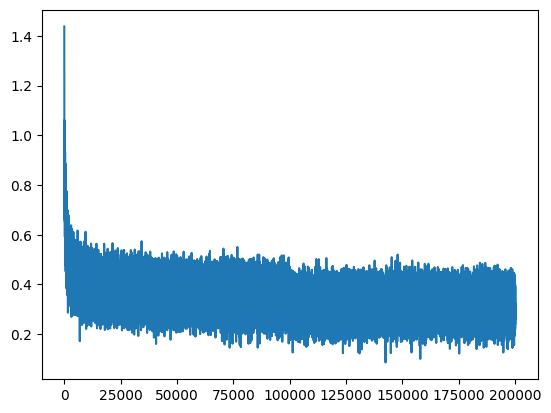

In [ ]:
plt.plot(steps, loss_track)

In [ ]:
    #NIlai loss atas train data
    emb_tr = C[X_tr]
    h = torch.tanh(emb_tr.view((-1,30)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y_tr)
    print(loss.item())
    acc = sum(F.softmax(logits, dim=1).argmax(dim=1) == Y_tr)/Y_tr.shape[0]
    print(f'accuracy : {acc}')

2.1264262199401855
accuracy : 0.3360961377620697


In [ ]:
    #NIlai loss atas dev data
    emb_dev = C[X_dev]
    emb_dev  = emb_dev.view((-1,30))

    h = torch.tanh(emb_dev @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y_dev)
    print(loss.item())
    acc = sum(F.softmax(logits, dim=1).argmax(dim=1) == Y_dev)/Y_dev.shape[0]
    print(f'accuracy : {acc}')

2.16919207572937
accuracy : 0.3261078894138336


Dari plot Learning Rate vs Loss kita bisa menentukan nilai Learning rate yang paling baik dalam kasus ini mungkin di angka 10**-1

setelah 10000 step, coba turunkan learning ratenya menjadi 10**-2 (Langkah ini disebut juga Learning Rate Decay)

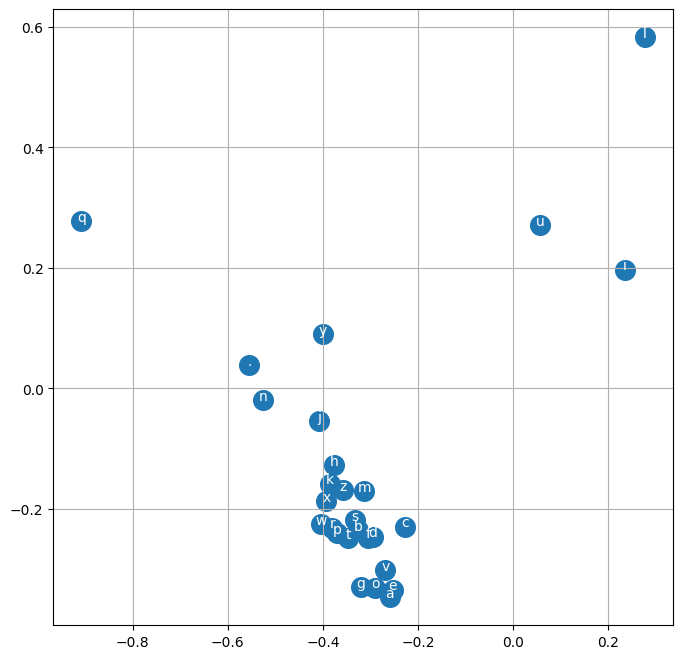

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', color = 'white')
plt.grid('minor')

In [ ]:
#Geenerate sample from model

g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    context = [0] * 3
    while True:
        #forward pass
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we meet the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


junide.
janasia.
palynn.
alin.
kai.
rito.
cassathe.
kalania.
zamilena.
jadedaile.
ambressiyanayla.
teziavaumeryn.
demmer.
ginsleigh.
ani.
core.
yae.
ocelynn.
brine.
keiki.
